In [1]:
%cd /content/drive/MyDrive/MCUT/R911R912
!ls

/content/drive/MyDrive/MCUT/R911R912
20220413		code	     test.csv
ARO1_pearsonr_corr.csv	data	     Untitled0.ipynb
ARO1特徵因子分析.ipynb	dataset.pkl  Untitled1.ipynb
ARO2_pearsonr_corr.csv	model
ARO2特徵因子分析.ipynb	PPT


In [2]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 5.5 MB/s 
     |████████████████████████████████| 419 kB 28.7 MB/s 
     |████████████████████████████████| 5.9 MB 31.8 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
import joblib
import requests
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import seed_everything
import random
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

In [4]:
data = joblib.load('20220413/PX產品MX含量 操作建議/dataset.pkl')
test_data = data[1]
batch_size = 1
hidden_size = 128
state_size = test_data['state'].shape[2]
request_size = test_data['value'].shape[1]
value_size = test_data['value'].shape[1]
action_size = test_data['action'].shape[2]
time_step = test_data['state'].shape[1]

In [16]:
data = joblib.load('20220413/PX產品MX含量 操作建議/dataset.pkl')
train_data = data[0]
batch_size = 1
hidden_size = 128
state_size = train_data['state'].shape[2]
request_size = train_data['value'].shape[1]
value_size = train_data['value'].shape[1]
action_size = train_data['action'].shape[2]
time_step = train_data['state'].shape[1]

In [5]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx

In [6]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = MADGRAD(actor.parameters() ,lr = 1e-3)
    
    self.critic = critic
    self.critic_optimizer = MADGRAD(critic.parameters() ,lr = 1e-3)
  
  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [17]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
actor.load_state_dict(torch.load('20220413/PX產品MX含量 操作建議/actor.pth'))
critic = R2D2(state_size+action_size,value_size,hidden_size)
critic.load_state_dict(torch.load('20220413/PX產品MX含量 操作建議/critic.pth'))
model = ActorCritic(actor,critic,time_step)

,0
count,5352.000000
mean,0.649828
std,0.260359
min,0.000000
25%,0.385908
50%,0.790562
75%,0.867485
max,1.000000


,0
count,5352.000000
mean,0.895115
std,0.060394
min,0.790568
25%,0.842371
50%,0.895810
75%,0.948039
max,0.999988


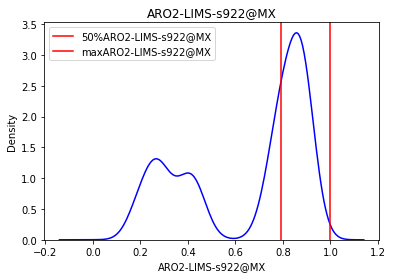

(5352, 8, 13)
(5352, 8, 6)
(5352, 1)
(5352, 1)


In [18]:
a = pd.DataFrame(train_data['value']).describe()
display(a)

train_data['request'] = None

for i in a.columns:
    if train_data['request'] == None:
        train_data['request'] = np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(train_data['value'].shape[0],1))
    else:
        train_data['request'] = np.hstack([train_data['request'],np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(train_data['value'].shape[0],1))])

b = pd.DataFrame(train_data['request']).describe()
display(b)

a = pd.DataFrame(train_data['value'],columns=train_data['value_col'])
for i in a.columns:
    sns.kdeplot(a[i],color='b')
    plt.axvline(x=a.describe().loc['50%',i], label= "50%"+str(i), c='r')
    plt.axvline(x=a.describe().loc['max',i], label= "max"+str(i), c='r')
    plt.legend()
    plt.title(i)
    plt.show()

# shape
print(train_data['state'].shape)
print(train_data['action'].shape)
print(train_data['value'].shape)
print(train_data['request'].shape)

# tensor
train_data['state'] = torch.FloatTensor(train_data['state'])
train_data['request'] = torch.FloatTensor(train_data['request'])
train_data['action'] = torch.FloatTensor(train_data['action'])
train_data['value'] = torch.FloatTensor(train_data['value'])



# data_iter
train_data = TensorDataset(train_data['state'],train_data['request'],train_data['action'],train_data['value'])
train_iter = DataLoader(train_data,batch_size=batch_size,shuffle=True)

,0
count,282.000000
mean,0.925071
std,0.017183
min,0.738203
25%,0.917906
50%,0.926309
75%,0.932612
max,0.967679


,0
count,282.000000
mean,0.946406
std,0.011796
min,0.926472
25%,0.935979
50%,0.945585
75%,0.956713
max,0.967534


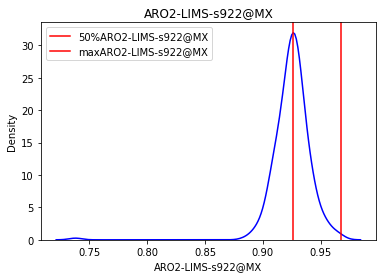

(282, 8, 13)
(282, 8, 6)
(282, 1)
(282, 1)


In [8]:
a = pd.DataFrame(test_data['value']).describe()
display(a)

test_data['request'] = None

for i in a.columns:
    if test_data['request'] == None:
        test_data['request'] = np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(test_data['value'].shape[0],1))
    else:
        test_data['request'] = np.hstack([test_data['request'],np.random.uniform(low=a.loc['50%'][i],high=a.loc['max'][i],size=(test_data['value'].shape[0],1))])

b = pd.DataFrame(test_data['request']).describe()
display(b)

a = pd.DataFrame(test_data['value'],columns=test_data['value_col'])
for i in a.columns:
    sns.kdeplot(a[i],color='b')
    plt.axvline(x=a.describe().loc['50%',i], label= "50%"+str(i), c='r')
    plt.axvline(x=a.describe().loc['max',i], label= "max"+str(i), c='r')
    plt.legend()
    plt.title(i)
    plt.show()

# shape
print(test_data['state'].shape)
print(test_data['action'].shape)
print(test_data['value'].shape)
print(test_data['request'].shape)

# tensor
test_data['state'] = torch.FloatTensor(test_data['state'])
test_data['request'] = torch.FloatTensor(test_data['request'])
test_data['action'] = torch.FloatTensor(test_data['action'])
test_data['value'] = torch.FloatTensor(test_data['value'])



# data_iter
test_data = TensorDataset(test_data['state'],test_data['request'],test_data['action'],test_data['value'])
test_iter = DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [19]:
wanna_ouput = [1]
real_value = []
pred_value = []
for i in tqdm(range(365)):
    s,r,a,v = next(iter(train_iter))
    s = s[0].reshape(-1,time_step,state_size)
    r = torch.full((1,1),wanna_ouput[0])
    a_ = model.actor_forward(s,r,eval=True) # 模型建議操作
    v_ = model.critic_forward(s,a,eval=True) # 模型預測輸出
    pred_value.append(v_.detach().numpy()[0])
    real_value.append(v.detach().numpy()[0])
pred_value = np.array(pred_value)
real_value = np.array(real_value)

  0%|          | 0/365 [00:00<?, ?it/s]

In [9]:
wanna_ouput = [1]
real_value = []
pred_value = []
for i in tqdm(range(427)):
    s,r,a,v = next(iter(test_iter))
    s = s[0].reshape(-1,time_step,state_size)
    r = torch.full((1,1),wanna_ouput[0])
    a_ = model.actor_forward(s,r,eval=True) # 模型建議操作
    v_ = model.critic_forward(s,a,eval=True) # 模型預測輸出
    pred_value.append(v_.detach().numpy()[0])
    real_value.append(v.detach().numpy()[0])
pred_value = np.array(pred_value)
real_value = np.array(real_value)

  0%|          | 0/427 [00:00<?, ?it/s]

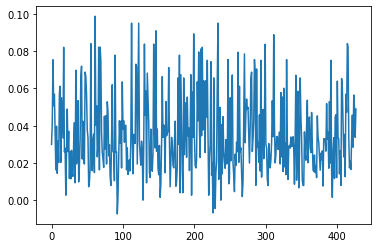

In [10]:
plt.plot(pd.Series((real_value - pred_value)[:,0]),label='pred')

In [ ]:
pred = (pred_value.reshape(-1, 1) * (1721-151) + 151)
real = (real_value.reshape(-1, 1) * (1721-151) + 151)

In [20]:
mm_y = data[0]['mm_value']

In [21]:
pred_value = mm_y.inverse_transform(pred_value.reshape(-1, 1)).reshape(-1,1)
real_value = mm_y.inverse_transform(real_value.reshape(-1, 1)).reshape(-1,1)

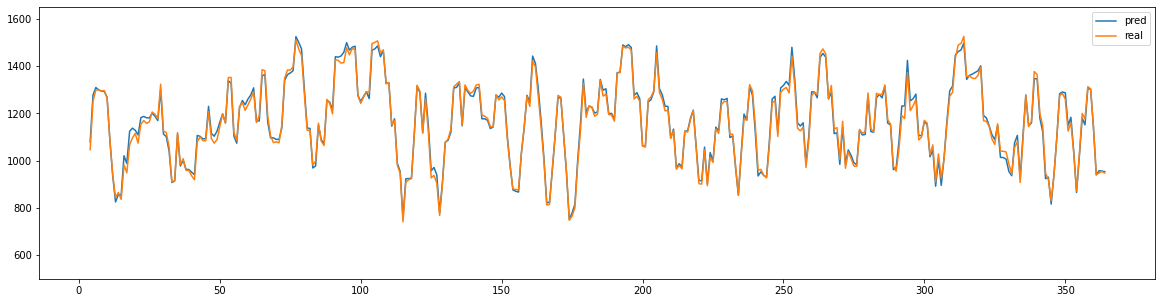

In [22]:
plt.figure(figsize=(20,5))
plt.plot(pd.Series(pred_value[:,0]).rolling(5).mean(),label='pred')
plt.plot(pd.Series(real_value[:,0]).rolling(5).mean(),label='real')
plt.legend()
plt.ylim(500, 1650)
plt.show()

In [23]:
import numpy as np

def mape(a, b): 
    return (np.abs(a - b)/a).mean()

print('mape',mape(real_value[:,0],pred_value[:,0]))

mape 0.030147254


In [24]:
from sklearn.metrics import mean_squared_error
print('rmse',np.sqrt(mean_squared_error(real_value[:,0],pred_value[:,0])))

rmse 40.88078


In [25]:
from sklearn.metrics import r2_score
r2_score(real_value[:,0], pred_value[:,0])

0.989523689526991